<a href="https://colab.research.google.com/github/olucascruz/analise_exploratoria/blob/main/Modelo_previsao_de_preco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from keras.models import Sequential
from keras.layers import Dense
import pickle

In [71]:
df = pd.read_csv('/content/drive/MyDrive/database/teste_indicium_precificacao.csv')
origin_df = df
df.head(3)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


## Clean Data

In [24]:
df.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [26]:
df["bairro_group"].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [27]:
df["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [28]:

def remove_outliers(df, column, min=0.05, max=0.95):
  percentile_05 = df[column].quantile(min)
  percentile_95 = df[column].quantile(max)
  df_clean = df[(percentile_05 <= df[column]) & (df[column] <= percentile_95)]
  print(column, df_clean.shape)
  return df_clean

def evaluate_model(y_test, _predicts, model):
    # Avaliar o modelo
    mse = mean_squared_error(y_test, _predicts)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, _predicts)
    r2 = r2_score(y_test, _predicts)
    print("Métricas de avaliação:")
    print("Erro Quadrático Médio (MSE):", mse)
    print("Raiz do Erro Quadrático Médio (RMSE):", rmse)
    print("Erro Médio Absoluto (MAE):", mae)
    print("Coeficiente de Determinação (R²):", r2)
    # Coeficientes da regressão
    if hasattr(model, 'intercept_') and hasattr(model, 'coef_'):
        print("Coeficiente (intercept):", model.intercept_)
        print("Coeficientes (slope):", model.coef_)
    else:
        print("O modelo não fornece coeficientes de interceptação e inclinação.")

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10), return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()


In [29]:
df = remove_outliers(df, "price")
df = remove_outliers(df, "minimo_noites")


price (44411, 16)
minimo_noites (43757, 16)


In [30]:

df_codificado = pd.get_dummies(df['bairro_group'])
df = pd.concat([df, df_codificado], axis=1)
df_codificado = pd.get_dummies(df['room_type'])
df = pd.concat([df, df_codificado], axis=1)

In [31]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,calculado_host_listings_count,disponibilidade_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2,355,0,0,1,0,0,1,0,0
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,1,365,0,0,1,0,0,0,1,0
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,1,194,0,1,0,0,0,1,0,0
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,1,0,0,0,1,0,0,1,0,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,1,129,0,0,1,0,0,1,0,0


In [32]:
df.corr(method="kendall")

<ipython-input-32-26198ef9f927>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method="kendall")


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
id,1.000000,0.412156,0.001240,0.050875,-0.015012,-0.047649,-0.216411,0.239805,0.097195,0.114785,0.038783,-0.045316,-0.017257,0.074674,0.018099,-0.041495,0.036314,0.021212
host_id,0.412156,1.000000,0.034966,0.077900,-0.054043,-0.099465,-0.084445,0.173132,0.104535,0.116248,0.056569,-0.108551,0.008718,0.120314,0.032028,-0.081698,0.073326,0.034378
latitude,0.001240,0.034966,1.000000,0.036633,0.076460,0.016095,-0.028978,-0.019103,0.004635,-0.010498,0.192310,-0.617532,0.541941,0.055988,-0.115159,-0.000943,-0.008430,0.037857
longitude,0.050875,0.077900,0.036633,1.000000,-0.282454,-0.089020,0.053862,0.086012,0.044726,0.065377,0.170289,0.121081,-0.413887,0.411319,-0.118998,-0.169854,0.170264,-0.000470
price,-0.015012,-0.054043,0.076460,-0.282454,1.000000,0.088530,-0.030596,-0.016064,-0.078064,0.043308,-0.078114,-0.148664,0.270007,-0.147092,-0.030403,0.546697,-0.527258,-0.082313
minimo_noites,-0.047649,-0.099465,0.016095,-0.089020,0.088530,1.000000,-0.124454,-0.213221,0.041629,0.045473,-0.039935,0.006507,0.071260,-0.096856,-0.022956,0.202146,-0.184075,-0.074383
numero_de_reviews,-0.216411,-0.084445,-0.028978,0.053862,-0.030596,-0.124454,1.000000,0.539957,0.051913,0.195967,0.016963,0.027456,-0.057302,0.034273,0.018181,0.011150,-0.007041,-0.016671
reviews_por_mes,0.239805,0.173132,-0.019103,0.086012,-0.016064,-0.213221,0.539957,1.000000,0.116647,0.286888,0.048371,-0.023520,-0.056672,0.093193,0.032466,-0.031619,0.029290,0.010120
calculado_host_listings_count,0.097195,0.104535,0.004635,0.044726,-0.078064,0.041629,0.051913,0.116647,1.000000,0.334039,0.016733,-0.048690,0.000393,0.064397,0.010091,-0.156626,0.146474,0.042092
disponibilidade_365,0.114785,0.116248,-0.010498,0.065377,0.043308,0.045473,0.195967,0.286888,0.334039,1.000000,0.065782,-0.057676,-0.029497,0.092687,0.048654,-0.016616,0.010424,0.025118


In [33]:
secure_copy = df
df = df[["price","latitude", "longitude", "Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island", "Entire home/apt", "Private room", "Shared room"]]

In [34]:
# Criar uma instância do StandardScaler
scaler = StandardScaler()

# Ajustar o scaler aos dados e transformá-los
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [35]:
df.head()

,price,latitude,longitude,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,1.387351,0.451403,-0.695580,-0.145242,-0.846463,1.129884,-0.361445,-0.084744,0.960665,-0.931259,-0.125453
1,0.329638,1.470545,0.221015,-0.145242,-0.846463,1.129884,-0.361445,-0.084744,-1.040945,1.073815,-0.125453
2,-0.530636,-0.808360,-0.169967,-0.145242,1.181387,-0.885046,-0.361445,-0.084744,0.960665,-0.931259,-0.125453
3,-0.657561,1.277203,0.175261,-0.145242,-0.846463,1.129884,-0.361445,-0.084744,0.960665,-0.931259,-0.125453
4,1.034780,0.341946,-0.503592,-0.145242,-0.846463,1.129884,-0.361445,-0.084744,0.960665,-0.931259,-0.125453


In [36]:
df.corr(method="kendall")

,price,latitude,longitude,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
price,1.000000,0.076460,-0.282454,-0.078114,-0.148664,0.270007,-0.147092,-0.030403,0.546697,-0.527258,-0.082313
latitude,0.076460,1.000000,0.036633,0.192310,-0.617532,0.541941,0.055988,-0.115159,-0.000943,-0.008430,0.037857
longitude,-0.282454,0.036633,1.000000,0.170289,0.121081,-0.413887,0.411319,-0.118998,-0.169854,0.170264,-0.000470
Bronx,-0.078114,0.192310,0.170289,1.000000,-0.122942,-0.128546,-0.052497,-0.012308,-0.037989,0.032903,0.020804
Brooklyn,-0.148664,-0.617532,0.121081,-0.122942,1.000000,-0.749159,-0.305950,-0.071732,-0.053689,0.064655,-0.043905
Manhattan,0.270007,0.541941,-0.413887,-0.128546,-0.749159,1.000000,-0.319896,-0.075002,0.120980,-0.129978,0.035491
Queens,-0.147092,0.055988,0.411319,-0.052497,-0.305950,-0.319896,1.000000,-0.030630,-0.088630,0.087829,0.003854
Staten Island,-0.030403,-0.115159,-0.118998,-0.012308,-0.071732,-0.075002,-0.030630,1.000000,0.002035,-0.001584,-0.001835
Entire home/apt,0.546697,-0.000943,-0.169854,-0.037989,-0.053689,0.120980,-0.088630,0.002035,1.000000,-0.969390,-0.130590
Private room,-0.527258,-0.008430,0.170264,0.032903,0.064655,-0.129978,0.087829,-0.001584,-0.969390,1.000000,-0.116830


In [37]:
y = df['price']
df.drop('price', axis="columns", inplace=True)
X = df

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Fazer previsões nos dados de teste
predicts = model_linear.predict(X_test)


In [40]:
evaluate_model(y_test, predicts, model_linear)

Métricas de avaliação:
Erro Quadrático Médio (MSE): 0.5774958404648083
Raiz do Erro Quadrático Médio (RMSE): 0.7599314709003755
Erro Médio Absoluto (MAE): 0.5551442589152285
Coeficiente de Determinação (R²): 0.4305540191582544
Coeficiente (intercept): -0.0018440948937508551
Coeficientes (slope): [-0.0870435  -0.17882292  0.00156476 -0.11456969  0.12710292  0.00479956
 -0.09911318  0.27644298 -0.25700551 -0.08042064]


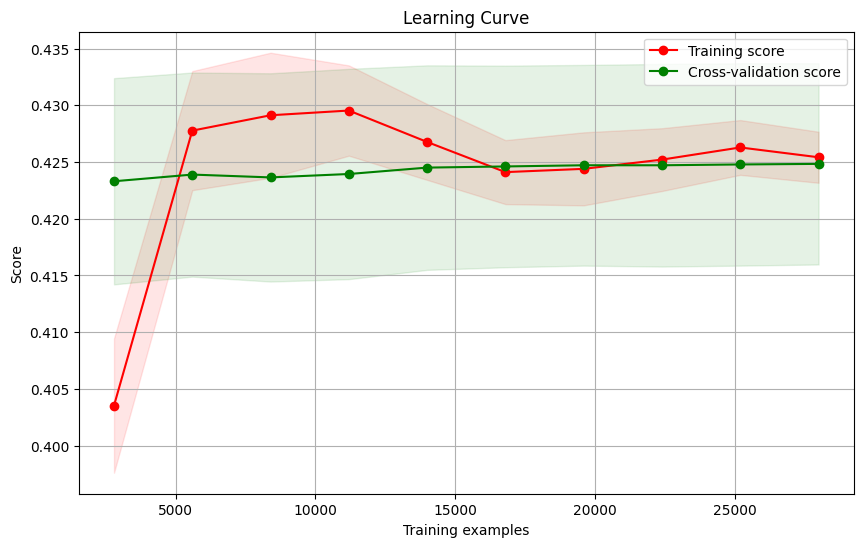

In [41]:
plot_learning_curve(model_linear, X_train, y_train)


In [42]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)

# Fazer previsões nos dados de teste
predicts_knn = model_knn.predict(X_test)


In [43]:
evaluate_model(y_test, predicts_knn, model_knn)

Métricas de avaliação:
Erro Quadrático Médio (MSE): 0.5819153813921408
Raiz do Erro Quadrático Médio (RMSE): 0.762833783593871
Erro Médio Absoluto (MAE): 0.5481538679609713
Coeficiente de Determinação (R²): 0.42619608332237113
O modelo não fornece coeficientes de interceptação e inclinação.


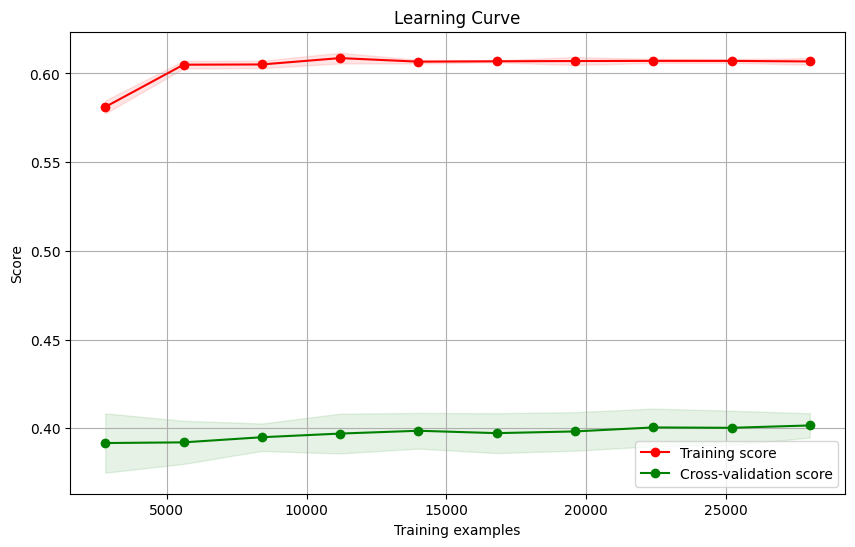

In [44]:
plot_learning_curve(model_knn, X_train, y_train)

In [45]:

model_desicion_tree = DecisionTreeRegressor()
model_desicion_tree.fit(X_train, y_train)

# Fazer previsões nos dados de teste
predicts_desicion_tree = model_desicion_tree.predict(X_test)


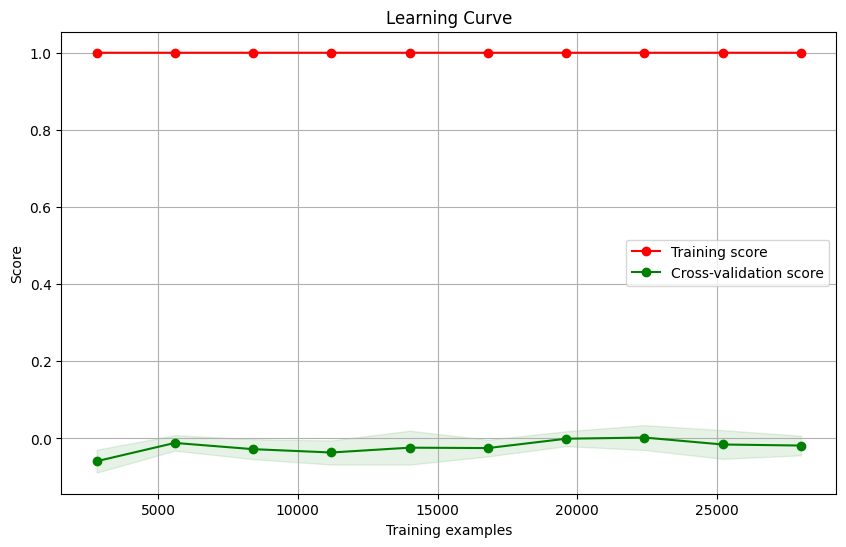

In [46]:
plot_learning_curve(model_desicion_tree, X_train, y_train)


In [47]:
evaluate_model(y_test, predicts_desicion_tree, model_desicion_tree)

Métricas de avaliação:
Erro Quadrático Médio (MSE): 0.9997157817438215
Raiz do Erro Quadrático Médio (RMSE): 0.9998578807729734
Erro Médio Absoluto (MAE): 0.7028055789750284
Coeficiente de Determinação (R²): 0.01421950772860292
O modelo não fornece coeficientes de interceptação e inclinação.


In [50]:

model_random_florest = RandomForestRegressor()
model_random_florest.fit(X_train, y_train)

# Fazer previsões nos dados de teste
predicts_random_florest = model_random_florest.predict(X_test)


In [51]:
evaluate_model(y_test, predicts_random_florest, model_random_florest)


Métricas de avaliação:
Erro Quadrático Médio (MSE): 0.5755860191843077
Raiz do Erro Quadrático Médio (RMSE): 0.7586738556087904
Erro Médio Absoluto (MAE): 0.5429894472455176
Coeficiente de Determinação (R²): 0.43243721896006027
O modelo não fornece coeficientes de interceptação e inclinação.


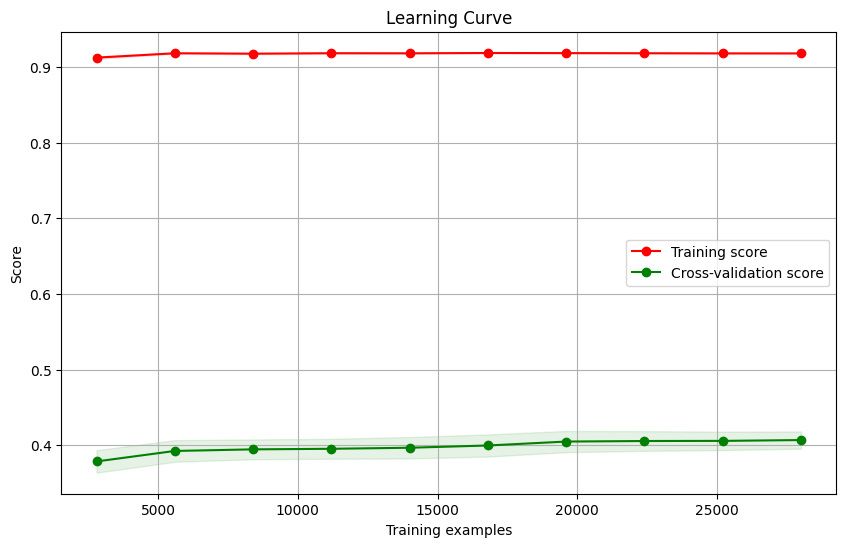

In [52]:
plot_learning_curve(model_random_florest, X_train, y_train)


In [61]:
# Criar modelo
model = Sequential()
model.add(Dense(64, input_dim=10, activation='relu'))  # Camada oculta com 64 neurônios e função de ativação ReLU
model.add(Dense(32, activation='relu'))  # Camada oculta com 32 neurônios e função de ativação ReLU
model.add(Dense(16, activation='tanh'))  # Camada oculta com 16 neurônios e função de ativação tanh
model.add(Dense(1, activation='linear'))              # Camada de saída com 1 neurônio para regressão linear

# Compilar modelo
model.compile(loss='mean_squared_error', optimizer='nadam')  # Usando erro quadrático médio como função de perda e otimizador Adamax

# Treinar modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)  # Treinar por 50 épocas com tamanho de lote de 32

# Fazer previsões
predicts = model.predict(X_test)

Epoch 1/50
1094/1094 [==============================] - 5s 3ms/step - loss: 0.5500
Epoch 2/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5353
Epoch 3/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5330
Epoch 4/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5318
Epoch 5/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5301
Epoch 6/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5292
Epoch 7/50
1094/1094 [==============================] - 3s 3ms/step - loss: 0.5292
Epoch 8/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5277
Epoch 9/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5272
Epoch 10/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5272
Epoch 11/50
1094/1094 [==============================] - 2s 2ms/step - loss: 0.5261
Epoch 12/50
1094/1094 [==============================] - 3s 2ms/step - loss: 0.5252
E

In [62]:
evaluate_model(y_test, predicts, model)

Métricas de avaliação:
Erro Quadrático Médio (MSE): 0.5171290077227483
Raiz do Erro Quadrático Médio (RMSE): 0.7191168248085622
Erro Médio Absoluto (MAE): 0.5207460575033594
Coeficiente de Determinação (R²): 0.490079383450825
O modelo não fornece coeficientes de interceptação e inclinação.


In [112]:
with open('modelo_keras.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)

In [107]:
data = {
 'id': [2595],
 'nome': ['Skylit Midtown Castle'],
 'host_id': [2845],
 'host_name': ['Jennifer'],
 'bairro_group': ['Manhattan'],
 'bairro': ['Midtown'],
 'latitude': [40.75362],
 'longitude': [-73.98377],
 'room_type': ['Entire home/apt'],
 'price': [225],
 'minimo_noites': [1],
 'numero_de_reviews': [45],
 'ultima_review': ['2019-05-21'],
 'reviews_por_mes': [0.38],
 'calculado_host_listings_count': [2],
 'disponibilidade_365': [355],
 'Bronx': [0],
 'Brooklyn': [0],
 'Manhattan': [1],
 'Queens': [0],
 'Staten Island': [0],
 'Entire home/apt': [1],
 'Private room': [0],
 'Shared room': [0]
}


df_test = pd.DataFrame(data)
df_test

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,calculado_host_listings_count,disponibilidade_365,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2,355,0,0,1,0,0,1,0,0


In [108]:

df_test = df_test[["latitude", "longitude", "Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island", "Entire home/apt", "Private room", "Shared room"]]
df_test

,latitude,longitude,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,40.75362,-73.98377,0,0,1,0,0,1,0,0


## Explicação do modelo

### Dado que o objetivo é prever um valor numérico, o modelo mais apropriado para essa tarefa é um modelo de regressão. Inicialmente, experimentei quatro tipos de modelos usando a biblioteca scikit-learn: regressão linear, KNeighborRegressor, decisionTreeRegressor e RandomFlorestRegressor. Após análise, a regressão linear mostrou-se mais eficaz. Em seguida, desenvolvi um modelo de regressão linear utilizando o Keras, o qual oferece maior flexibilidade para personalização e ajuste de parâmetros. Ao final, obtive as seguintes métricas:

Métricas de avaliação: <br>
  Erro Quadrático Médio (MSE): 0.5171290077227483 <br>
  Raiz do Erro Quadrático Médio (RMSE): 0.7191168248085622 <br>
  Erro Médio Absoluto (MAE): 0.5207460575033594 <br>
  Coeficiente de Determinação (R²): 0.490079383450825 <br>
  O modelo não fornece coeficientes de interceptação e inclinação. <br>